In [1]:
import os
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/Users/gimtaeyeong/opt/anaconda3/envs/TIL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 하이퍼 파라미터 값 튜닝

In [2]:
CFG = {
    'IMG_SIZE': 128, # 이미지 크기
    'EPOCHS': 50, # Epoch
    'LEARNING_RATE': 2e-2, # 학습률
    'BATCH_SIZE': 12, # Batch_size
    'SEED': 41, # SEED
}

### 재현성을 위한 SEED 고정

In [3]:
import random 
import numpy as np


def seed_fixed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_fixed(CFG['SEED'])

In [4]:
import pandas as pd

hand_df = pd.read_csv('./data/train.csv')
hand_df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [5]:
hand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


### 데이터 전처리

In [6]:
hand_df['label'][hand_df['label'] == '10-1'] = 10 # 10-1 -> 10
hand_df['label'][hand_df['label'] == '10-2'] = 0 # 10-1 -> 0
hand_df['label'] = hand_df['label'].apply(lambda x: int(x)) # DataType: Object -> Int

In [7]:
hand_df.head()

,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [8]:
hand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ KB


In [9]:
from glob import glob


def get_train_data(data_dir):
    img_path_list = []
    label_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(hand_df['label'])

    return img_path_list, label_list


def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    return img_path_list

In [10]:
all_img_path, all_label = get_train_data('./data/train')
test_img_path = get_test_data('./data/test')

In [11]:
all_label[0:5]

[0, 10, 3, 8, 9]

In [12]:
all_img_path[0]

'./data/train/001.png'

### Custom Dataset 생성

In [13]:
import torchvision.datasets as datasets # 이미지 데이터셋 모음
import torchvision.transforms as transforms # 이미지 크기 조정
import cv2

from torch.utils.data import DataLoader # 학습 및 배치를 위한 도구
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list


    def __getitem__(self, index): # index번째 data를 return한다.
        img_path = self.img_path_list[index]

        # get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

    
    def __len__(self):
        return len(self.img_path_list)

### Split Train & Valid

In [14]:
# 8 : 2
train_len = int(len(all_img_path) * 0.8)
valid_len = int(len(all_img_path) - train_len)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [15]:
print(len(train_img_path))
print(len(valid_img_path))

686
172


In [16]:
train_transform = transforms.Compose([
    transforms.ToPILImage(), # Numpy list -> Image
    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), # 이미지 사이즈 조정
    transforms.ToTensor(), # Image -> Tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

### DataLoader 생성

In [17]:
# Custom Dataset을 통한 train dataset 생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
# train dataset을 통한 traind_loaer 생성
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

# valid
valid_dataset = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [18]:
train_batches = len(train_loader)
valid_batches = len(valid_loader)

print('total train images: ', train_len, 'total train batches: ', train_batches)
print('total valid images: ', valid_len, 'total valid batches: ', valid_batches)

total train images:  686 total train batches:  58
total valid images:  172 total valid batches:  15


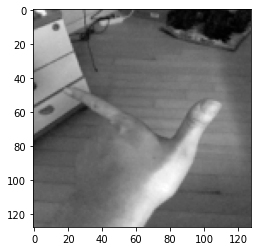

label: 0


In [19]:
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) # iter는 반복 가능한 객체에서 iterator를 반환하고, next는 iterator에서 값을 차례대로 꺼낸다

img = train_features[0]
label = train_label[0]
plt.imshow(img[0], cmap='gray')
plt.show()
print(f'label: {label}')

In [20]:
print(f'Feature batch_shape: {train_features.size()}')
print(f'Batch Labels shape: {train_labels}')

Feature batch_shape: torch.Size([12, 3, 128, 128])
Batch Labels shape: tensor([6, 2, 4, 1, 4, 7, 2, 6, 5, 6, 6, 9])


### 모델 정의

In [21]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함된 라이브러리


class CNNclassifier(nn.Module):
    def __init__(self):
        super(CNNclassifier, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(3136, 11)
        )

    
    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)

        y = torch.flatten(y, start_dim=1)

        y = self.fc_layer(y)

        return y

### 모델 학습을 위한 하이퍼 파라미터 지정

In [22]:
import torch.optim as optim

model = CNNclassifier().to(device)
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = None

In [ ]:
def train(model, optimizer, train_loader, scheduler, device):
    model.to(device)
    n = len(train_loader)

    crit = nn.CrossEntropyLoss().to(device)
    best_acc = 0

    for epoch in range(1, CFG['EPOCHS'] + 1):
        # train
        model.train()
        running_loss = 0.0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            y_hat = model(img)
            loss = crit(y_hat, label)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print('[%d] Train loss: %.10f' % (epoch, running_loss / len(train_loader)))

        if scheduler is not None:
            scheduler.step()


        # valid
        model.eval()
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(valid_loader)):
                img, label = img.to(device), label.to(device)

                y_hat = model(img)
                valid_loss = crit(y_hat, label)
                pred = y_hat.argmax(dim=1, keepdim=True) # 11개의 class 중에서 가장 높은 값을 가진 label을 추출
                correct += pred.eq(label.view_as(pred)).sum().item() # y_hat과 label 값이 맞을 때 1씩 더한다.
        valid_acc = 100 * correct / len(valid_loader.dataset)
        print('Valid set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(valid_loss / len(valid_loader), correct, len(valid_loader.dataset), 100 * correct / len(valid_loader.dataset)))

        if best_acc < valid_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), './model/best_model.pth')
            print('Best Model Changed')

In [ ]:
train(model, optimizer, train_loader, scheduler, device)

### test 값에 대한 예측

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            y_hat = model(img)
            y_hat = y_hat.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(y_hat.tolist())

    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

checkpoint = torch.load('./model/best_model.pth')
model = CNNclassifier().to(device)
model.load_state_dict(checkpoint)

preds = predict(model, test_loader, device)
preds[0:5]

### 제출

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['label'] = preds

In [ ]:
submission['label'][submission['label'] == 10] = '10-1'
submission['label'][submission['label'] == 0] = '10-2'
submission['label'] = submission['label'].apply(lambda x: str(x)) # int -> ojbect

In [ ]:
submission.to_csv('baseline.csv', index=False)